In [1]:
import pandas as pd
from river import compose
from river import linear_model
from river import metrics
from river import preprocessing
from river import stream
from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.pyplot as plt
import numpy as np
from river import evaluate
from river import optim
import datetime as dt

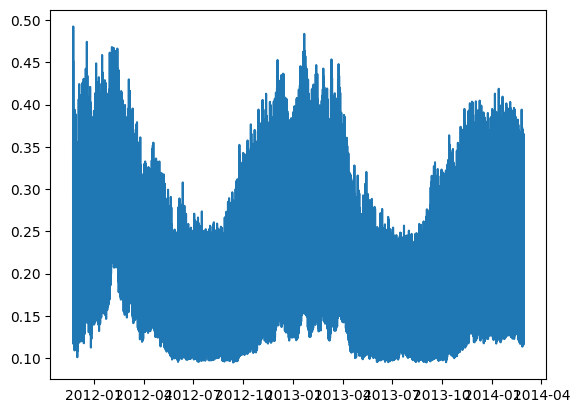

In [2]:
# Load the data
df = pd.read_csv('merged_data.csv')


# Convert the 'utc_timestamp' column to datetime
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Drop the first row
df = df.dropna()

df['day_of_week'] = df['DateTime'].dt.dayofweek
df['hour_of_day'] = df['DateTime'].dt.hour
df['month'] = df['DateTime'].dt.month

df

#plot the data
plt.plot(df['DateTime'], df['MeanEnergyConsumption'])

In [3]:
#check for break in timestamps
import pandas as pd

# Assuming df is your DataFrame and 'timestamp' is your timestamp column
df = df.sort_values('DateTime')

# Calculate the difference between current and previous timestamp
df['time_diff'] = df['DateTime'].diff()

# Define a threshold for a break, e.g., 1 hour
threshold = pd.Timedelta(hours=1)

# Check if there are any breaks
has_breaks = any(df['time_diff'] > threshold)

print(f"Data has breaks: {has_breaks}")

Data has breaks: False


In [4]:
#df['MeanEnergyConsumption'].plot()

#drop the utc_timestamp column
#df = df.drop('utc_timestamp', axis=1)

stream = iter(df.itertuples(index=False))
stream = iter([(x._asdict(), y) for x, y in zip(df.drop('MeanEnergyConsumption', axis=1).itertuples(index=False), df['MeanEnergyConsumption'])])
print(next(stream))

({'DateTime': Timestamp('2011-11-23 09:00:00'), 'temperature_2m': 4.25, 'precipitation': 0.0, 'cloud_cover': 30.300001, 'cloud_cover_low': 1.0, 'cloud_cover_mid': 0.0, 'cloud_cover_high': 98.0, 'is_day': 1.0, 'sunshine_duration': 2924.7007, 'day_of_week': 2, 'hour_of_day': 9, 'month': 11, 'time_diff': NaT}, 0.355)


{'MAE': MAE: 0.033551, 'Step': 19863, 'Prediction': 0.1297885637146277}


C:\Users\Stijn\AppData\Local\Temp\ipykernel_29924\3827959975.py:55: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(mdates.date2num(df['DateTime']), df['MeanEnergyConsumption'], linestyle='-', marker=None, alpha=0.5, label='Actual Values')
C:\Users\Stijn\AppData\Local\Temp\ipykernel_29924\3827959975.py:57: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(mdates.date2num(timestamps), predictions, linestyle='-', marker=None, alpha=0.5, label='Predictions')


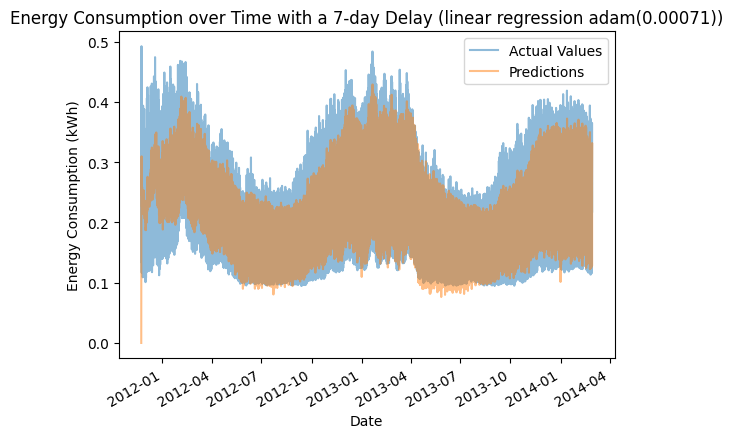

C:\Users\Stijn\AppData\Local\Temp\ipykernel_29924\3827959975.py:85: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(mdates.date2num(week_data['DateTime']), week_data['MeanEnergyConsumption'], linestyle='-', marker=None, label='Actual Values')
C:\Users\Stijn\AppData\Local\Temp\ipykernel_29924\3827959975.py:88: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(mdates.date2num(week_predictions['DateTime']), week_predictions['Predictions'], linestyle='-', marker=None, label='Predictions')


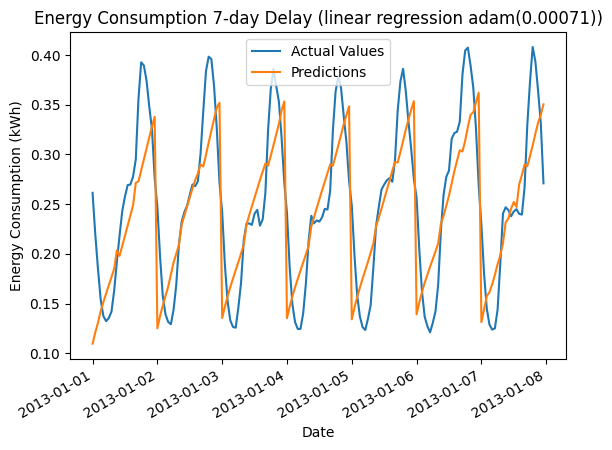

19864
19863


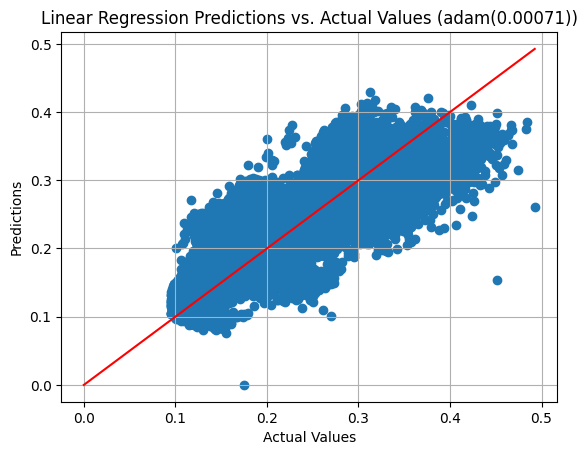

19863
19863


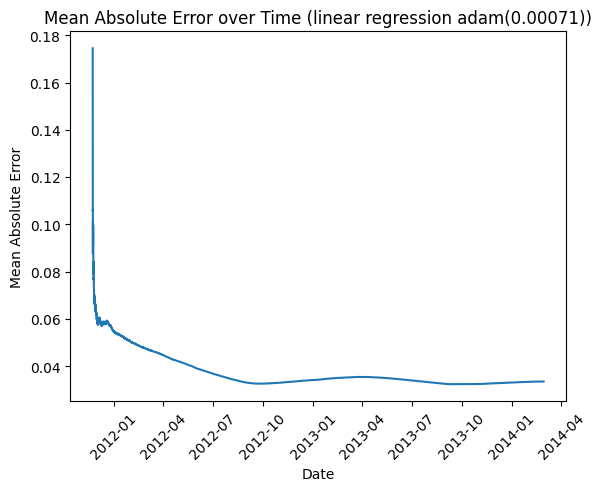

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates




# Define the target transformer
class TargetScaler(preprocessing.StandardScaler):
    def transform_one(self, y):
        return super().transform_one({'y': y})['y']

    def inverse_transform_one(self, y):
        return super().inverse_transform_one({'y': y})['y']

# Create a pipeline that includes scaling the target variable
model = compose.Pipeline(
    compose.Select('hour_of_day', 'month', 'day_of_week','temperature_2m', 'precipitation','cloud_cover','cloud_cover_low','cloud_cover_mid','cloud_cover_high','is_day','sunshine_duration'),
    preprocessing.StandardScaler(),
    preprocessing.TargetStandardScaler(
        regressor=linear_model.LinearRegression(optimizer=optim.Adam(0.00071)),
    )
)

# Evaluate the model
steps = evaluate.iter_progressive_val_score(
    dataset=stream,
    model=model,
    metric=metrics.MAE(),
    moment='DateTime',
    delay=dt.timedelta(days=0),
    step=1,
    yield_predictions=True,
)

start_date =  df['DateTime'].min()
end_date =  df['DateTime'].max()
# Initialize lists to store the predictions and their timestamps
predictions = []
timestamps = pd.date_range(start=start_date, end=end_date, freq='1h')
#remove the first timestamp
timestamps = timestamps[1:]
Mea_overtime = []

length = 0
for step in steps:
    length += 1
    predictions.append(step["Prediction"])
    Mea_overtime.append(str(step["MAE"]).split(" ")[1])
print(step)

# Plot the predictions
fig, ax = plt.subplots()
# Also plot the actual values with transparency and a label for the legend
ax.plot_date(mdates.date2num(df['DateTime']), df['MeanEnergyConsumption'], linestyle='-', marker=None, alpha=0.5, label='Actual Values')
# Plot the predictions with transparency and a label for the legend
ax.plot_date(mdates.date2num(timestamps), predictions, linestyle='-', marker=None, alpha=0.5, label='Predictions')
ax.set_title('Energy Consumption over Time with a 7-day Delay (linear regression adam(0.00071))')
ax.set_ylabel('Energy Consumption (kWh)')
ax.set_xlabel('Date')
fig.autofmt_xdate()
ax.legend()
plt.show()


#plotting of the predictions and actual values for a week

# Define the start and end dates
start_date = pd.to_datetime('2013-01-01')
end_date = start_date + pd.DateOffset(weeks=1)
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Filter the data
week_data = df[(df['DateTime'] >= start_date) & (df['DateTime'] < end_date)]

#combine the predictions and timestamps into a dataframe
df_prediction = pd.DataFrame({'DateTime': timestamps, 'Predictions': predictions})

#convert datetime to datetime object
df_prediction['DateTime'] = pd.to_datetime(df_prediction['DateTime'])
week_predictions = df_prediction[(df_prediction['DateTime'] >= start_date) & (df_prediction['DateTime'] < end_date)]
fig, ax = plt.subplots()

# Also plot the actual values with transparency and a label for the legend
ax.plot_date(mdates.date2num(week_data['DateTime']), week_data['MeanEnergyConsumption'], linestyle='-', marker=None, label='Actual Values')

# Plot the predictions with transparency and a label for the legend
ax.plot_date(mdates.date2num(week_predictions['DateTime']), week_predictions['Predictions'], linestyle='-', marker=None, label='Predictions')
ax.set_ylabel('Energy Consumption (kWh)')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Energy Consumption 7-day Delay (linear regression adam(0.00071))')

# Rotate date labels automatically
fig.autofmt_xdate()

plt.show()


import numpy as np

print(len(df['MeanEnergyConsumption']))
print(len(predictions))

# Create scatter plot of the predictions and actual values
plt.scatter(df['MeanEnergyConsumption'][1:], predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title('Linear Regression Predictions vs. Actual Values (adam(0.00071))')

# Add a red line for perfect predictions
min_val = min(min(df['MeanEnergyConsumption'][1:]), min(predictions))
max_val = max(max(df['MeanEnergyConsumption'][1:]), max(predictions))
plt.plot([min_val, max_val], [min_val, max_val], color='red')

# Add a grid
plt.grid(True)

plt.show()


print(len(Mea_overtime))
print(len(timestamps))

#convert the Mea overtime to int
Mea_overtime = [float(i) for i in Mea_overtime]

#plot the Mean Absolute Error over time
plt.plot(timestamps,Mea_overtime)
plt.xlabel('Date')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error over Time (linear regression adam(0.00241))')
#rotate the date labels
plt.xticks(rotation=45)
plt.show()



In [6]:
from river import optim
from sklearn.model_selection import ParameterGrid

# Define the learning rates and optimizers
learning_rates = [0.01, 0.1, 1.0]
optimizers = [optim.SGD, optim.Adam, optim.RMSProp]

# Create the parameter grid
param_grid = {
    'optimizer': [opt(lr) for opt in optimizers for lr in learning_rates],
}

# Initialize the best MAE and optimizer
best_mae = float('inf')
best_optimizer = None

# Initialize lists to store the predictions and their timestamps
ListOfListOfPredictions = []
listofParams = []

# Iterate over the parameter grid
for params in ParameterGrid(param_grid):
    print(f'Testing Linear Regression with {params["optimizer"]} optimizer')

    # Create a new model with the current optimizer
    model = linear_model.LinearRegression(optimizer=params['optimizer'])

    # Evaluate the model
    steps = evaluate.iter_progressive_val_score(
        dataset=stream,
        model=model.clone(),
        metric=metrics.MAE(),
        moment='DateTime',
        delay=dt.timedelta(days=7),
        step=1,
        yield_predictions=True,
    )

    # Initialize the last MAE and predictions
    last_mae = 0
    predictions = []

    # Iterate over the steps and update the last MAE and predictions
    for step in steps:
        last_mae = step["MAE"]
        predictions.append(step["Prediction"])

    # Convert the last MAE to a float
    last_mae = float(str(last_mae).split(" ")[1])

    # If the current MAE is better than the best MAE, update the best MAE and optimizer
    if last_mae != 0 and last_mae < best_mae:
        best_mae = last_mae
        best_optimizer = params['optimizer']

    # Store the predictions and parameters
    ListOfListOfPredictions.append(predictions)
    listofParams.append(params)

print(f'Best MAE: {best_mae}')
print(f'Best optimizer: {best_optimizer}')

# Plotting of the predictions and actual values for a week
start_date = df['DateTime'].min()
end_date = df['DateTime'].max()
timestamps = pd.date_range(start=start_date, end=end_date, freq='1h')

for predictions, params in zip(ListOfListOfPredictions, listofParams):
    # Combine the predictions and timestamps into a dataframe
    df_prediction = pd.DataFrame({'DateTime': timestamps, 'Predictions': predictions})

    # Convert datetime to datetime object
    df_prediction['DateTime'] = pd.to_datetime(df_prediction['DateTime'])

    # Define the start and end dates for the week
    start_date_week = pd.to_datetime('2013-01-01')
    end_date_week = start_date_week + pd.DateOffset(weeks=1)

    # Filter the data for the week
    week_data = df[(df['DateTime'] >= start_date_week) & (df['DateTime'] < end_date_week)]
    week_predictions = df_prediction[(df_prediction['DateTime'] >= start_date_week) & (df_prediction['DateTime'] < end_date_week)]

    # Plot the actual values and predictions
    fig, ax = plt.subplots()
    ax.plot_date(mdates.date2num(week_data['DateTime']), week_data['MeanEnergyConsumption'], linestyle='-', marker=None, label='Actual Values')
    ax.plot_date(mdates.date2num(week_predictions['DateTime']), week_predictions['Predictions'], linestyle='-', marker=None, label='Predictions')
    ax.set_ylabel('Energy Consumption (kWh)')
    ax.set_xlabel('Date')
    ax.legend()
    ax.set_title(f'Linear Regression with {params["optimizer"]}')

    # Rotate date labels automatically
    fig.autofmt_xdate()

    plt.show()

Testing Linear Regression with SGD optimizer


IndexError: list index out of range